In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from glob import glob

In [29]:
fnames = glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T0.700_P0.*.lammpstrj')
#fnames = fnames + glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T0.700_P0.0000020000.lammpstrj')
#fnames = glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/P_0_old/T_0.700_small/dumplin/dump.npt_nose_T0.700_P0.1.0000002000.lammpstrj')
arrays = [np.loadtxt(f, skiprows=9)[:,2:5] for f in fnames]
coordinates = np.array(arrays)
temperature = float(0.700)
side=6.
dim = len(coordinates)
n_particles = len(coordinates[0])
spacial_dim = 3
dim_ics = n_particles * spacial_dim

In [30]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

# a context tensor to send data to the right device and dtype via '.to(ctx)'
ctx = torch.zeros([], device=device, dtype=dtype)

# a brief check if this module is the main executable (or imported)
main = (__name__ == "__main__")

In [31]:
import sys
sys.path.insert(0, "/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/B_GEN/bgflow")
import bgflow as bg

In [32]:
from  bgflow.distribution.energy import LennardJonesPotentialPPP
rm = 2**(1./6.)
target = LennardJonesPotentialPPP(dim = dim_ics, n_particles = n_particles, side = side, oscillator = False, rm=rm)

In [33]:
def plot_energy(coordinates, target):
    xs = torch.Tensor(coordinates)
    xs = xs.view(-1,10,3)
    energy = target.energy(xs).detach().numpy()
    
    x=np.arange(1,len(energy)+1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, energy)

    plt.subplot(1, 2, 2)
    counts, bins = np.histogram(energy, density=True)
    plt.yscale("log")
    plt.stairs(counts, bins)

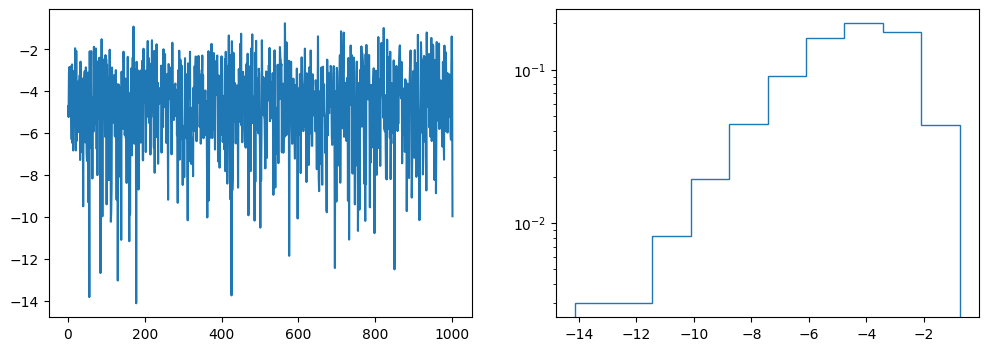

In [34]:
plot_energy(coordinates, target)

In [35]:
from bgflow import NormalDistribution

mean = torch.Tensor(coordinates[10]).view(dim_ics)
cov = torch.zeros(dim_ics, dim_ics)
cov = cov.fill_diagonal_(0.003)

prior = NormalDistribution(dim_ics, mean=mean, cov=cov) #, shape = [n_particles,spacial_dim])

In [38]:
data_prior = prior._sample_with_temperature(2000, temperature=temperature)
data_prior.shape #view(-1, 10, 3).shape
#plot_energy(data_prior, target)

torch.Size([2000, 30])

In [39]:
xs = torch.Tensor(data_prior)
xs = xs.view(-1,10,3)
energy = target.energy(xs).detach().numpy()

In [40]:
data_prior.shape

torch.Size([2000, 30])

In [41]:
energy[energy>200]
np.argwhere(energy>200)
#tensor = torch.Tensor(data_prior[245]).view(10,3)
#target.energy(tensor)

array([], shape=(0, 2), dtype=int64)

In [42]:
# define a MCMC sampler to sample from the target energy

from bgflow import GaussianMCMCSampler

init_state = torch.Tensor(coordinates[10])
init_state.shape

torch.Size([10, 3])

In [43]:
def constraint(x):
    x = torch.where((x > side).clone().detach(), x, x - side * torch.floor(x/side))
    x = torch.where((x < 0).clone().detach(), x, x - side * torch.floor(x/side))
    return x

In [44]:
target_sampler = GaussianMCMCSampler(target, init_state=init_state, box_constraint=constraint, temperature=temperature)

In [45]:
# sample some data 

#data = target_sampler.sample(100000)
data = target_sampler.sample(1000)
data=data.view(-1,30)

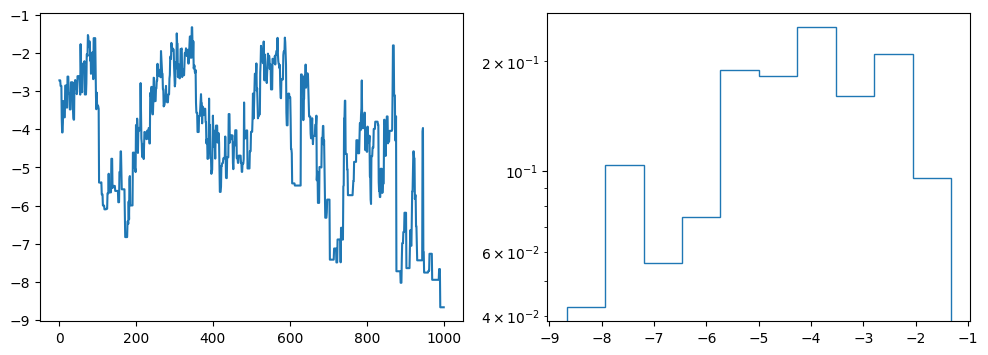

In [46]:
plot_energy(data, target)

In [47]:
print(data.shape, coordinates.shape, data_prior.shape, dim_ics)

torch.Size([1000, 30]) (1001, 10, 3) torch.Size([2000, 30]) 30


In [48]:
from bgflow.utils.types import is_list_or_tuple
from bgflow.utils.types import assert_numpy

class LossReporter:
    """
        Simple reporter use for reporting losses and plotting them.
    """
    
    def __init__(self, *labels):
        self._labels = labels
        self._n_reported = len(labels)
        self._raw = [[] for _ in range(self._n_reported)]
    
    def report(self, *losses):
        assert len(losses) == self._n_reported
        for i in range(self._n_reported):
            self._raw[i].append(assert_numpy(losses[i]))
    
    def plot(self, n_smooth=10):
        fig, axes = plt.subplots(self._n_reported, sharex=True)
        if not isinstance(axes, np.ndarray):
            axes = [axes]
        fig.set_size_inches((8, 4 * self._n_reported), forward=True)
        for i, (label, raw, axis) in enumerate(zip(self._labels, self._raw, axes)):
            raw = assert_numpy(raw).reshape(-1)
            kernel = np.ones(shape=(n_smooth,)) / n_smooth
            smoothed = np.convolve(raw, kernel, mode="valid")
            axis.plot(smoothed)
            axis.set_xscale("log")
            axis.set_yscale("log")
            axis.set_ylabel(label)
            if i == self._n_reported - 1:
                axis.set_xlabel("Iteration")
                
    def recent(self, n_recent=1):
        return np.array([raw[-n_recent:] for raw in self._raw])

In [49]:
# define a flow with RNVP coupling layers

from bgflow.nn import (
    DenseNet,
    SequentialFlow, 
    CouplingFlow, 
    AffineFlow, 
    SplitFlow, 
    InverseFlow, 
    SwapFlow,
    AffineTransformer
)



# here we aggregate all layers of the flow
layers = []

# start with a splitting layer which splits the input tensor into two 
# flow channels with tensors of half dimensionality
layers.append(SplitFlow( dim_ics//2 , dim=1))
#layers.append(SplitFlow( n_particles//2 , dim=1))

# now add coupling layers
n_coupling_layers = 4
for _ in range(n_coupling_layers):
    
    # we need to swap dimensions for the mixing
    layers.append(SwapFlow())
    
    # now set up a coupling block
    layers.append(CouplingFlow(
        # we use a affine transformation to transform the RHS conditioned on the LHS
        AffineTransformer(
            # use simple dense nets for the affine shift/scale
            shift_transformation=DenseNet([dim_ics//2, 100, 100, dim_ics//2], activation=torch.nn.ReLU()),
            scale_transformation=DenseNet([dim_ics//2, 100, 100, dim_ics//2], activation=torch.nn.ReLU())
            #shift_transformation=DenseNet([n_particles//2, 100, 100, n_particles//2], activation=torch.nn.ReLU()),
            #scale_transformation=DenseNet([n_particles//2, 100, 100, n_particles//2], activation=torch.nn.ReLU())
        )
    ))
    
# finally, we have to merge the two channels again into one tensor
layers.append(InverseFlow(SplitFlow( dim_ics//2 , dim=1)))
    
# now define the flow as a sequence of all operations stored in layers
flow = SequentialFlow(layers)

In [50]:
# having a flow and a prior, we can now define a Boltzmann Generator

from bgflow import BoltzmannGenerator

bg = BoltzmannGenerator(prior, flow, target)

In [51]:
# initial training with likelihood maximization on data set

from bgflow.utils.train import IndexBatchIterator

n_batch = 5
batch_iter = IndexBatchIterator(len(data), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=5e-3)

n_epochs = 3
n_report_steps = 50

reporter = LossReporter("NLL")

In [52]:
for epoch in range(n_epochs):
    for it, idxs in enumerate(batch_iter):
        #print(it, idxs, len(data))

        batch = data[idxs]
        #print(batch.shape)
        optim.zero_grad()
        
        # negative log-likelihood of the batch is equal to the energy of the BG
        nll = bg.energy(batch, temperature=temperature).mean()
        nll.backward()
        
        reporter.report(nll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, NLL: {3:.4}".format(
                    epoch,
                    it,
                    len(batch_iter),
                    *reporter.recent(1).ravel()
                ), end="")
        


epoch: 2, iter: 150/200, NLL: 325.90303

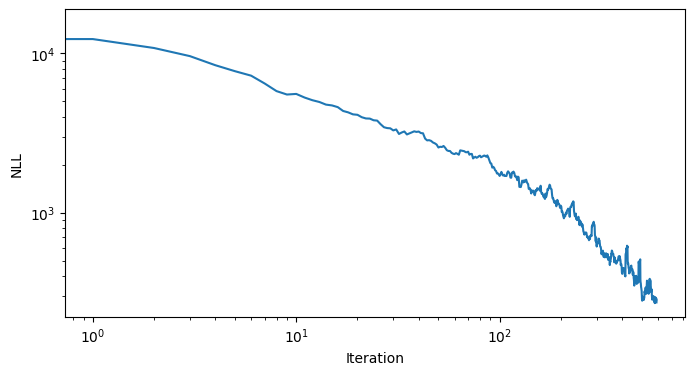

In [53]:
reporter.plot()

In [54]:
sample = bg.sample(500, temperature=temperature)

In [55]:
torch.where(sample[1] > 6 )

(tensor([], dtype=torch.int64),)

In [56]:
# train with convex mixture of NLL and KL loss

from bgflow.utils.train import IndexBatchIterator

n_kl_samples = 256
n_batch = 256
batch_iter = IndexBatchIterator(len(data), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=5e-3)

n_epochs = 5
n_report_steps = 50

# mixing parameter
lambdas = torch.linspace(1., 0.5, n_epochs)

reporter = LossReporter("NLL", "KLL")

In [57]:
for epoch, lamb in enumerate(lambdas):
    for it, idxs in enumerate(batch_iter):
        batch = data[idxs]
        
        optim.zero_grad()
        
        # negative log-likelihood of the batch is equal to the energy of the BG
        nll = bg.energy(batch).mean()
        
        # aggregate weighted gradient
        (lamb * nll).backward()
        
        # kl divergence to the target
        kll = bg.kldiv(n_kl_samples).mean()

        # aggregate weighted gradient
        ((1. - lamb) * kll).backward()
        
        reporter.report(nll, kll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, lambda: {3}, NLL: {4:.4}, KLL: {5:.4}".format(
                    epoch,
                    it,
                    len(batch_iter),
                    lamb,
                    *reporter.recent(1).ravel()
                ), end="")

AssertionError: Input at index 0 as wrong shape torch.Size([256, 30]) instead of torch.Size([10, 3])